# RSNA-MICCAI Kaggle Competition

The objective of this project is to predict the likelihood of MGMT promoter methylation given four types of structural multi-parametric MRI scans: 
- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)

This is useful for predicing receptiveness to chemotherapy because the MGMT promoter fights against the agents used in chemotherapy.  When the MGMT promoter is methylated, the promoter is disabled, thereby making that system receptive to chemotherapy.

# Let's First Explore the Data

In [1]:
# Importing relevant packages for EDA
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom


## What is the Output?

As said in the introduction, the goal of our model is to predict the probability of methylation.  In the sample submission below, there is a list of BraTS2IDs with corresponding probabilities of 0.5 each.

In [2]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head(10)

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
5,47,0.5
6,79,0.5
7,80,0.5
8,82,0.5
9,91,0.5


When training, we'll be given binary labels for the presence of MGMT promoter methylation.

In [3]:
train_labels = pd.read_csv("data/train_labels.csv")
train_labels.head(10)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


## What is the Input?

For each patient (who has an ID), we have four different types of multi-paramteric MRI scans.  Each MRI scan is a 3D scan broken down into a folder of 2D images.  To start, let's take a look at one image from one of the FLAIR training scans. 

Nummber of FLAIR Images = 400
Nummber of T1w Images = 33
Nummber of T1wCE Images = 129
Nummber of T2w Images = 408


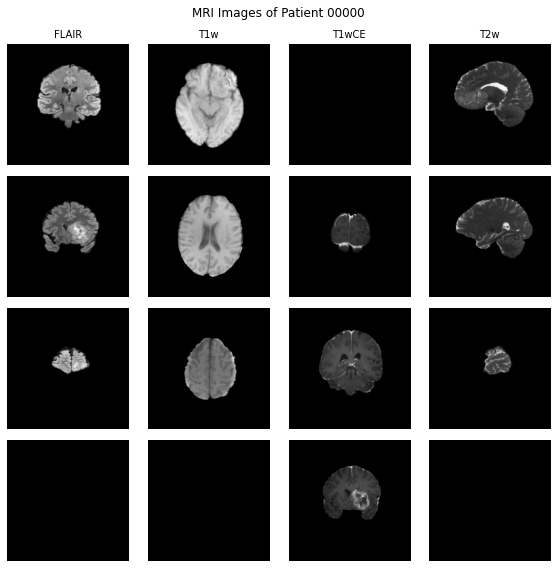

In [4]:
patient_path = "data/train/00000/"
mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
quartiles = [1/5, 2/5, 3/5, 4/5]

fig, ax = plt.subplots(4, 4, figsize=(8, 8), tight_layout=True)
for i, mri_type in enumerate(mri_types):
    filenames = [x for x in os.listdir(os.path.join(patient_path, mri_type))]
    print(f"Nummber of {mri_type} Images = {len(filenames)}")
    for j, quartile in enumerate(quartiles):
        filename = filenames[math.floor(len(filenames)*quartile)]

        example_image = pydicom.filereader.dcmread(
            os.path.join(patient_path, mri_type, filename)).pixel_array

        ax[j, i].imshow(example_image, cmap="gray")
        ax[j, i].set_axis_off()
        if not j:
            ax[j, i].set_title(mri_type, size=10)

fig.suptitle("MRI Images of Patient 00000")
fig.show()


## Data Management

Let's add folder names to each row of the training labels.

In [5]:
train_labels["imfolder"] = ["{0:05d}".format(
    id) for id in train_labels["BraTS21ID"]]
train_labels.head(10)


,BraTS21ID,MGMT_value,imfolder
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
5,8,1,00008
6,9,0,00009
7,11,1,00011
8,12,1,00012
9,14,1,00014


Let's add the number of MRI scans of each type for each patient.

In [13]:
train_path = "data/train"
train_labels.reindex(columns=mri_types, fill_value=0)
train_labels[mri_types] = train_labels[mri_types].astype(int)

for i in train_labels.index:
    for mri_type in mri_types:
        train_labels.at[i, mri_type] = sum(len(files) for _, _, files in os.walk(
            os.path.join(train_path, train_labels.at[i, "imfolder"], mri_type)))

train_labels.head(10)


,BraTS21ID,MGMT_value,imfolder,FLAIR,T1w,T1wCE,T2w
0,0,1,00000,400,33,129,408
1,2,1,00002,129,31,129,384
2,3,0,00003,129,33,129,408
3,5,1,00005,400,28,129,424
4,6,1,00006,129,32,129,408
5,8,1,00008,168,30,150,168
6,9,0,00009,240,32,360,288
7,11,1,00011,129,33,129,129
8,12,1,00012,400,31,304,448
9,14,1,00014,216,352,352,129


Unfortunately, it looks like the number of MRI images is not consistent across patients and MRI types.  Let's see how many patients have the same number of images across MRI types.

In [17]:
num_allsame = sum([train_labels.at[i, "FLAIR"] == train_labels.at[i, "T1w"]
                   == train_labels.at[i, "T1wCE"] == train_labels.at[i, "T2w"]
                   for i in train_labels.index])
print(f"{num_allsame = }")


num_allsame =63
